In [1]:
import numpy as np
from glob import glob 
import os,sys
import pr2_utils
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots, figure
from tqdm import tqdm
import pickle
import cv2
import yaml
import time
%matplotlib inline

In [2]:
sb = 475.143600050775 / 1000

In [3]:
robot_T_Lidar = np.asarray([[0.00130201, 0.796097, 0.605167, 0.8349], \
    [0.999999, -0.000419027, -0.00160026, -0.0126869],\
    [-0.00102038, 0.605169, -0.796097, 1.76416], \
    [0, 0, 0, 1]])

def meta_constructor(loader, node):
    value = loader.construct_mapping(node)
    return value

yaml.add_constructor(u'tag:yaml.org,2002:opencv-matrix', meta_constructor)
left_camera = open("../code/param/left_camera.yaml")
left_camera = yaml.load(left_camera, Loader = yaml.FullLoader)
right_camera = open("../code/param/right_camera.yaml")
right_camera = yaml.load(right_camera, Loader = yaml.FullLoader)

In [4]:
K = np.asarray(left_camera['projection_matrix']['data']).reshape(3,-1)

In [5]:
K

array([[775.3723555 ,   0.        , 619.47309113,   0.        ],
       [  0.        , 775.3723555 , 257.18049049,   0.        ],
       [  0.        ,   0.        ,   1.        ,   0.        ]])

In [20]:
robot_T_stereo = np.asarray([[-0.00680499, -0.0153215, 0.99985, 1.64239],[ -0.999977, 0.000334627, -0.00680066, 0.247401],\
    [-0.000230383, -0.999883, -0.0153234,  1.58411],[0, 0, 0 ,1]])

In [6]:
with open('../map3/map_parameters.pkl', 'rb') as f: 
    X = pickle.load(f)
    MAP = X[0]
    
traj = MAP['traj']

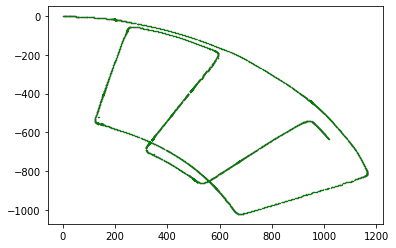

In [7]:
plt.scatter(traj[:,0], traj[:,1], c = 'g', s= 0.001)

In [8]:
stereo_left_t = []
stereo_right_t = []
folder = "../code/stereo_images/"

for file in os.listdir(folder +  'stereo_left'): 
    if file.endswith('.png'): 
        filename = file.split('.')[0]
        stereo_left_t.append(int(filename))

for file in os.listdir(folder +  'stereo_right'): 
    if file.endswith('.png'): 
        filename = file.split('.')[0]
        stereo_right_t.append(int(filename))
stereo_left_t.sort()

stereo_right_t.sort()
stereo_left_t = np.asarray(stereo_left_t).reshape(-1,1)
stereo_right_t = np.asarray_chkfinite(stereo_right_t).reshape(-1,1)
stereo_t = np.hstack((stereo_left_t, stereo_right_t))
stereo_t_diff = stereo_right_t - stereo_left_t
index = np.where(stereo_t_diff != 0)[0]
stereo_left_t = np.delete(stereo_left_t, index, axis = 0) 
stereo_right_t = np.delete(stereo_right_t, index, axis = 0) 

In [9]:
def compute_stereo(filename, img = []):
    path_l = f'../code/stereo_images/stereo_left/{filename}.png'
    path_r = f'../code/stereo_images/stereo_right/{filename}.png' 
    # print(path_l)

    image_l = cv2.imread(path_l, 0)
    image_r = cv2.imread(path_r, 0)

    image_l = cv2.cvtColor(image_l, cv2.COLOR_BAYER_BG2BGR)
    image_r = cv2.cvtColor(image_r, cv2.COLOR_BAYER_BG2BGR)

    image_l_gray = cv2.cvtColor(image_l, cv2.COLOR_BGR2GRAY)
    image_r_gray = cv2.cvtColor(image_r, cv2.COLOR_BGR2GRAY)

    stereo = cv2.StereoBM_create(numDisparities=32, blockSize=9) 
    disparity = stereo.compute(image_l_gray, image_r_gray)
    img.append(disparity)
    fig, (ax3) = plt.subplots(1, 1)
    ax3.imshow(disparity, cmap='gray')
    ax3.set_title('Disparity Map')
    plt.savefig(f'../code/disparity/disparity_{filename}.png', format = 'png')
    plt.close()
    return img

# Run below three cells only if you need to get the disparity and rgb images. Otherwise run (*) directly

In [10]:
# for i in tqdm(range(len(stereo_left_t))): 
# # for i in tqdm(range(200)): 
#     d_img = compute_stereo(int(stereo_left_t[i]))
# d_img = np.asarray(d_img)
# # print(d_img.shape)
# # print(d_img[0,250,350])

In [11]:
# rgb_img = []
# folder = '../code/stereo_images/stereo_left/'
# for i in tqdm(range(len(stereo_left_t))): 
#     image = f'{int(stereo_left_t[i])}.png'
#     img = (cv2.imread(folder + image,0))
#     img = cv2.cvtColor(img, cv2.COLOR_BAYER_BG2BGR)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     rgb_img.append(img)
# rgb_img = np.asarray(rgb_img)

In [12]:
# with open('texture_img_2.pkl', 'wb') as f: 
#     pickle.dump([d_img, rgb_img],f)
    

# *

In [13]:
with open('texture_img_2.pkl', 'rb') as f: 
    X = pickle.load(f)
d_img = X[0]
rgb_img = X[1]

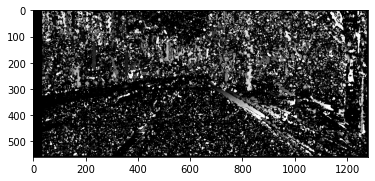

In [14]:
plt.imshow(~d_img[0], cmap = 'Greys')
plt.show(block = True)

In [15]:
for i in range(len(rgb_img)): 
    image = rgb_img[i]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    rgb_img[i] = image

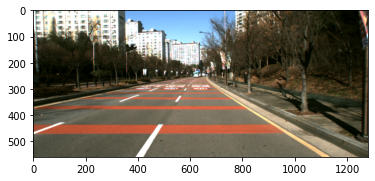

In [16]:
plt.imshow(rgb_img[0])

In [17]:
lidar_time, lidar_data = pr2_utils.read_data_from_csv('../code/sensor_data/lidar.csv')
encoder_time, encoder_data = pr2_utils.read_data_from_csv('../code/sensor_data/encoder.csv')
fog_time, fog_data = pr2_utils.read_data_from_csv('../code/sensor_data/fog.csv')
lidar_time, fog_time, encoder_time = lidar_time * (10**(-9)), fog_time * (10**(-9)), encoder_time*(10**(-9))

Equation : $$[u,v,1] = K * \frac{1}{Zo} [Xo, Yo, Zo, 1]$$

In [18]:
xMax,yMax = 1500,400
xMin, yMin = -300, -1500
res = 0.75
sizey = sizex = int((xMax - xMin)/res)
texture_map_2 =  np.zeros((sizex,sizey,3)).astype(np.int16)

In [21]:
for i in tqdm(range(len(stereo_left_t))):
    disp = np.zeros((560,1280))
    disp = cv2.normalize(d_img[i], disp,  alpha=0, beta=255,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    z = (K[0][0] * sb)/d_img[i]
    z[z > 100] = 0
    depth = z.reshape(1,-1)
    uv = np.indices((560,1280))
    uv = uv.reshape((2,-1))
    grid_uv = np.vstack((uv[1], uv[0]))
    grid = np.vstack((grid_uv, np.ones((1, 560*1280))))
    
    xyz_o = depth * (np.linalg.inv(K[0:3 , 0:3]) @ grid) #Xo, Yo, Zo i.e. optical frame coordinates 
    xyz_o = np.vstack((xyz_o, np.ones((1, xyz_o.shape[-1]))))  #Homogenise by adding row of ones
    xyz_robot = robot_T_stereo @ xyz_o #Convert from optical frame to regular frame and regular frame camera to robot frame
    
    #Image coordinates in robot frame. Need to convert to world frame using the transformation of robot to world
    #Now time comes into play. Each stereo has a time, find corresponding encoder time and get pose of robot
    
    encoder_t = np.abs(int(stereo_left_t[i])*10**(-9) - lidar_time).argmin()
    robot_pose = MAP['traj'][encoder_t]
    
    sx,sy,theta = robot_pose[0], robot_pose[1], robot_pose[2]
    
    world_T_robot = np.asarray([[np.cos(theta),-np.sin(theta), 0, sx], \
                                [np.sin(theta) , np.cos(theta) , 0 , sy], \
                                [0, 0, 1, 0], [0,0,0,1]])
    
    #Get coordinates in world frame 
    xyz_world = world_T_robot @ xyz_robot #4 * (560*1280) matrix, x,y,z of each of the pixel
#     print(f"world points : {xyz_world}")
    ground = (xyz_world[2] > 0.2)
    xyz_world = xyz_world[:,ground] #select only the points that are near to the road
    
    xyz_o = xyz_o[:,ground]
    uv_permissible = np.around(np.divide(K @ xyz_o, xyz_o[2])[:2]).astype(np.int16)
    x_ground= (np.ceil((xyz_world[0,:] - xMin)/res).astype(np.int16) - 1)
    y_ground= (np.ceil((xyz_world[1,:] - yMin)/res).astype(np.int16) - 1)
    texture_map_2[x_ground, y_ground, :] = rgb_img[i][uv_permissible[1], uv_permissible[0], :]

  0%|          | 0/1113 [00:00<?, ?it/s]/home/sambaran/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/sambaran/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
100%|██████████| 1113/1113 [01:20<00:00, 13.79it/s]


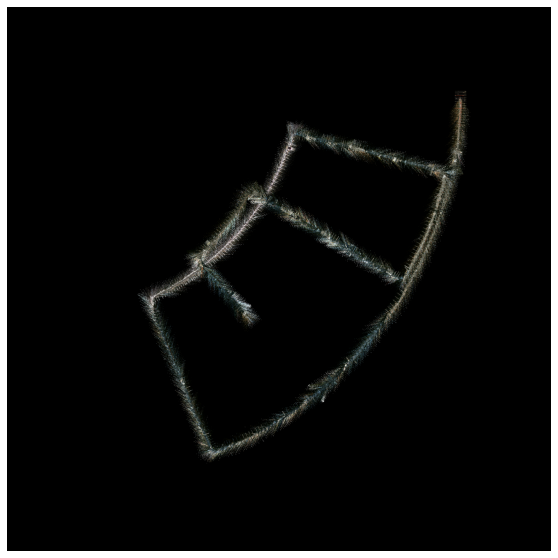

In [23]:
fig = plt.figure(figsize = (25,10))
plt.axis('off')
plt.imshow(texture_map_2)
plt.show(block = True)